# FDS Project

### Loading Libraries as specified in requirements.txt

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec  # Add this import
import seaborn as sns
import statsmodels.formula.api as smf
import csv 

# PCA, K-Nearest Neighbours 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Randomness,sampling simulations
from scipy.stats import uniform, norm, expon

# Bootstrap
import statsmodels.formula.api as smf # Regression library
from scipy.stats import norm # Object to with member functions to do with normal distributions

# logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

### Loading datasets and Cleaning

In [3]:
# Categories cleaning 
categories_loc = os.path.join(os.getcwd(), 'steam-insights', 'categories.csv')
categories = pd.read_csv(categories_loc)

categories['category'] = categories['category'].astype('string')
categories= categories.groupby('app_id')['category'].apply(list).reset_index()
categories.head()

,app_id,category
0,10,"[Family Sharing, Multi-player, Online PvP, PvP..."
1,20,"[Family Sharing, Multi-player, Online PvP, PvP..."
2,30,"[Family Sharing, Multi-player, Valve Anti-Chea..."
3,40,"[Family Sharing, Multi-player, Online PvP, PvP..."
4,50,"[Family Sharing, Multi-player, Remote Play Tog..."


In [4]:
# Reviews cleaning 

reviews_loc = os.path.join(os.getcwd(), 'steam-insights', 'reviews.csv')
reviews = pd.read_csv(reviews_loc, 
                     na_values=['\\N'],  # Treat \N as NULL
                     keep_default_na=True,
                     on_bad_lines='skip')

#print("Missing values in reviews DataFrame:", reviews.isna().sum())

# Drop columns with many na's
reviews = reviews.drop(columns=['metacritic_score', 'reviews', 'recommendations', 
                              'steamspy_score_rank', 'steamspy_positive', 
                              'steamspy_negative'], axis=1)

reviews = reviews.dropna(subset=['steamspy_user_score','review_score'])

reviews['app_id'] = reviews['app_id'].astype(int)
reviews['review_score'] = reviews['review_score'].astype(int)
reviews['review_score_description'] = reviews['review_score_description'].astype('string')
reviews['steamspy_user_score'] = pd.to_numeric(reviews['steamspy_user_score'], errors='coerce')
reviews = reviews.dropna(subset=['steamspy_user_score'])

reviews.head()



C:\Users\Georg\AppData\Local\Temp\ipykernel_67452\230650386.py:4: DtypeWarning: Columns (0,1,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv(reviews_loc,


,app_id,review_score,review_score_description,positive,negative,total,steamspy_user_score
0,10,9,Overwhelmingly Positive,235403.0,6207.0,241610.0,0.0
1,20,8,Very Positive,7315.0,1094.0,8409.0,0.0
2,30,8,Very Positive,6249.0,672.0,6921.0,0.0
3,40,8,Very Positive,2542.0,524.0,3066.0,0.0
4,50,9,Overwhelmingly Positive,22263.0,1111.0,23374.0,0.0


In [5]:
# steamspy cleaning 

steamspy_loc = os.path.join(os.getcwd(), 'steam-insights', 'steamspy_insights.csv')
steamspy = pd.read_csv(steamspy_loc, on_bad_lines='skip', na_values=[r'\N'])  # Ensure \N is treated as NA
steamspy = steamspy.dropna(subset=['developer','genres','publisher','languages'])
steamspy['developer'] = steamspy['developer'].astype('string')
steamspy['publisher'] = steamspy['publisher'].astype('string')
#steamspy['languages'] = steamspy['languages'].astype('string')
steamspy['genres'] = steamspy['genres'].astype('string')

# Extract and calculate average owners from the range
def extract_owners_average(owners_range):
    try:
        # Extract the numbers from the range (format like "10,000,000 .. 20,000,000")
        parts = owners_range.replace(',', '').split('..')
        min_owners = int(parts[0].strip())
        max_owners = int(parts[1].strip())
        return (min_owners + max_owners) / 2
    except (ValueError, AttributeError, IndexError):
        return None

# Apply the function to create a new column
steamspy['owners_average'] = steamspy['owners_range'].apply(extract_owners_average)

steamspy.head()


,app_id,developer,publisher,owners_range,concurrent_users_yesterday,playtime_average_forever,playtime_average_2weeks,playtime_median_forever,playtime_median_2weeks,price,initial_price,discount,languages,genres,owners_average
0,10,Valve,Valve,"10,000,000 .. 20,000,000",11457,0,0,0,0,999.0,999.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,15000000.0
1,20,Valve,Valve,"5,000,000 .. 10,000,000",52,0,0,0,0,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,7500000.0
2,30,Valve,Valve,"5,000,000 .. 10,000,000",82,0,0,0,0,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Spain",Action,7500000.0
3,40,Valve,Valve,"5,000,000 .. 10,000,000",6,0,0,0,0,499.0,499.0,0.0,"English, French, German, Italian, Spanish - Sp...",Action,7500000.0
4,50,Gearbox Software,Valve,"2,000,000 .. 5,000,000",99,0,0,0,0,499.0,499.0,0.0,"English, French, German, Korean",Action,3500000.0


In [6]:
# Games cleaning 

games_loc = os.path.join(os.getcwd(), 'steam-insights', 'games.csv')
games = pd.read_csv(
    games_loc, 
    encoding='utf-8',
    escapechar='\\',  # Handle escape characters
    quotechar='"',    # Specify quote character
    on_bad_lines='skip'
)


games['release_date'] = pd.to_datetime(games['release_date'], format='%Y-%m-%d', errors='coerce')
games['name'] = games['name'].astype('string')
games['type'] = games['type'].astype('string')

# Convert to string to ensure we're working with strings
games['price_overview'] = games['price_overview'].astype(str)

# Extract final price
games['price_final'] = games['price_overview'].str.extract(r'"final":\s*(\d+)').astype(float) / 100

# Extract initial price
games['price_initial'] = games['price_overview'].str.extract(r'"initial":\s*(\d+)').astype(float) / 100

# Extract currency
games['currency'] = games['price_overview'].str.extract(r'"currency":\s*"([^"]+)')

games['currency'] = games['currency'].astype('string')



games = games.drop(columns=['price_overview', 'languages'])

paid_games = games[(games['type'] == 'game') & (games['is_free'] == 0)]
paid_games = paid_games.dropna(subset=['price_final','release_date'])

free_games = games[(games['type'] == 'game') & (games['is_free']==1)]
free_games = free_games.drop(columns=['price_final','price_initial','currency'])
free_games = free_games.dropna(subset=['release_date'])

demos = games[games['type'] != 'game']
demos = demos.drop(columns=['price_final','price_initial','currency'])
demos = demos.dropna(subset=['release_date'])


In [7]:
# genres cleaning
genres_loc = os.path.join(os.getcwd(), 'steam-insights', 'genres.csv')
genres = pd.read_csv(genres_loc)

genres['genre'] = genres['genre'].astype('string')

genres.head()


,app_id,genre
0,10,Action
1,20,Action
2,30,Action
3,40,Action
4,50,Action


In [8]:
# tags cleaning 
tags_loc = os.path.join(os.getcwd(), 'steam-insights', 'tags.csv')
tags = pd.read_csv(tags_loc)

tags['tag'] = tags['tag'].astype('string')
tags= tags.groupby('app_id')['tag'].apply(list).reset_index()

tags.head()

,app_id,tag
0,10,"[1980s, 1990's, Action, Assassin, Classic, Com..."
1,20,"[1990's, Action, Class-Based, Classic, Co-op, ..."
2,30,"[Action, Class-Based, Classic, Co-op, Difficul..."
3,40,"[1990's, Action, Arena Shooter, Classic, Co-op..."
4,50,"[1990's, Action, Adventure, Aliens, Atmospheri..."


### Filtered and merged paid games

In [9]:
# Paid games dataset 
filtered_paid_games = paid_games.copy()
filtered_paid_games = filtered_paid_games.merge(genres, on='app_id', how='inner')
filtered_paid_games = filtered_paid_games[(filtered_paid_games['genre'] != 'Audio Production') & 
                    (filtered_paid_games['genre'] != 'Accounting') &
                    (filtered_paid_games['genre'] != 'Utilities') & 
                    (filtered_paid_games['genre'] != 'Video Production') &
                    (filtered_paid_games['genre'] != 'Design & Illustration') & 
                    (filtered_paid_games['genre'] != 'Game Development') &
                    (filtered_paid_games['genre'] != 'Web Publishing') & 
                    (filtered_paid_games['genre'] != 'Software Training') &
                    (filtered_paid_games['genre'] != 'Animation & Modeling') & 
                    (filtered_paid_games['genre'] != 'Photo Editing') &
                    (filtered_paid_games['genre'] != 'Documentary') &
                    (filtered_paid_games['genre'] != 'Education') &
                    (filtered_paid_games['genre'] != 'Episodic') &
                    (filtered_paid_games['genre'] != 'Movie') &
                    (filtered_paid_games['genre'] != 'Short') &
                    (filtered_paid_games['genre'] != 'Tutorial') &
                    (filtered_paid_games['genre'] != '360 Video') &
                    (filtered_paid_games['genre'] != 'Free To Play')]
filtered_paid_games['release_year'] = filtered_paid_games['release_date'].dt.year

# Merge on Positive Reviews
filtered_paid_games = filtered_paid_games.merge(reviews[['app_id', 'review_score', 'review_score_description', 'positive', 'negative', 'total']], on='app_id', how='inner')
# Avoid duplication of Games
filtered_paid_games = filtered_paid_games.groupby(['app_id', 'name', 'release_date', 'is_free',
                                               'type', 'price_final', 'price_initial',
                                               'currency', 'release_year', 'positive', 
                                               'review_score', 'review_score_description', 
                                               'negative', 'total'])['genre'].agg(list).reset_index()
# Merge on concurrent players 
filtered_paid_games = filtered_paid_games.merge(steamspy[['app_id','concurrent_users_yesterday','owners_average']], on='app_id', how='inner')
# Merge on tags 
filtered_paid_games = filtered_paid_games.merge(tags[['app_id','tag']], on='app_id', how='inner')
# Merge on Categories 
filtered_paid_games = filtered_paid_games.merge(categories[['app_id','category']], on='app_id', how='inner')
# Extract year 
filtered_paid_games['release_year'] = filtered_paid_games['release_date'].dt.year
# Calculate the price difference from initial release to current 
filtered_paid_games['price_difference'] = filtered_paid_games['price_initial']-filtered_paid_games['price_final']

# Drop columns not needed 
filtered_paid_games.drop(columns=['is_free','type'], inplace=True)

filtered_paid_games.head()

,app_id,name,release_date,price_final,price_initial,currency,release_year,positive,review_score,review_score_description,negative,total,genre,concurrent_users_yesterday,owners_average,tag,category,price_difference
0,10,Counter-Strike,2000-11-01,8.19,8.19,EUR,2000,235403.0,9,Overwhelmingly Positive,6207.0,241610.0,[Action],11457,15000000.0,"[1980s, 1990's, Action, Assassin, Classic, Com...","[Family Sharing, Multi-player, Online PvP, PvP...",0.0
1,20,Team Fortress Classic,1999-04-01,4.99,4.99,EUR,1999,7315.0,8,Very Positive,1094.0,8409.0,[Action],52,7500000.0,"[1990's, Action, Class-Based, Classic, Co-op, ...","[Family Sharing, Multi-player, Online PvP, PvP...",0.0
2,30,Day of Defeat,2003-05-01,4.99,4.99,EUR,2003,6249.0,8,Very Positive,672.0,6921.0,[Action],82,7500000.0,"[Action, Class-Based, Classic, Co-op, Difficul...","[Family Sharing, Multi-player, Valve Anti-Chea...",0.0
3,40,Deathmatch Classic,2001-06-01,4.99,4.99,EUR,2001,2542.0,8,Very Positive,524.0,3066.0,[Action],6,7500000.0,"[1990's, Action, Arena Shooter, Classic, Co-op...","[Family Sharing, Multi-player, Online PvP, PvP...",0.0
4,50,Half-Life: Opposing Force,1999-11-01,4.99,4.99,EUR,1999,22263.0,9,Overwhelmingly Positive,1111.0,23374.0,[Action],99,3500000.0,"[1990's, Action, Adventure, Aliens, Atmospheri...","[Family Sharing, Multi-player, Remote Play Tog...",0.0


### Filtered and merged free games

In [10]:
# Free games dataset 
filtered_free_games = free_games.copy()
filtered_free_games = filtered_free_games.merge(genres, on='app_id', how='inner')
filtered_free_games = filtered_free_games[(filtered_free_games['genre'] != 'Audio Production') & 
          (filtered_free_games['genre'] != 'Accounting') &
          (filtered_free_games['genre'] != 'Utilities') & 
          (filtered_free_games['genre'] != 'Video Production') &
          (filtered_free_games['genre'] != 'Design & Illustration') & 
          (filtered_free_games['genre'] != 'Game Development') &
          (filtered_free_games['genre'] != 'Web Publishing') & 
          (filtered_free_games['genre'] != 'Software Training') &
          (filtered_free_games['genre'] != 'Animation & Modeling') & 
          (filtered_free_games['genre'] != 'Photo Editing') &
          (filtered_free_games['genre'] != 'Documentary') &
          (filtered_free_games['genre'] != 'Education') &
          (filtered_free_games['genre'] != 'Episodic') &
          (filtered_free_games['genre'] != 'Movie') &
          (filtered_free_games['genre'] != 'Short') &
          (filtered_free_games['genre'] != 'Tutorial') &
          (filtered_free_games['genre'] != '360 Video') &
          (filtered_free_games['genre'] != 'Free To Play')]
filtered_free_games['release_year'] = filtered_free_games['release_date'].dt.year

# Merge on Positive Reviews
filtered_free_games = filtered_free_games.merge(reviews[['app_id', 'review_score', 'review_score_description', 'positive', 'negative', 'total']], on='app_id', how='inner')
# Avoid duplication of Games
filtered_free_games = filtered_free_games.groupby(['app_id', 'name', 'release_date', 'is_free',
                         'type', 'release_year', 'positive', 
                         'review_score', 'review_score_description', 
                         'negative', 'total'])['genre'].agg(list).reset_index()
# Merge on concurrent players 
filtered_free_games = filtered_free_games.merge(steamspy[['app_id','concurrent_users_yesterday','owners_average']], on='app_id', how='inner')
# Merge on tags 
filtered_free_games = filtered_free_games.merge(tags[['app_id','tag']], on='app_id', how='inner')
# Merge on Categories 
filtered_free_games = filtered_free_games.merge(categories[['app_id','category']], on='app_id', how='inner')
# Extract year 
filtered_free_games['release_year'] = filtered_free_games['release_date'].dt.year
# Drop columns not needed 
filtered_free_games.drop(columns=['is_free','type'], inplace=True)

# Correlation and PCA

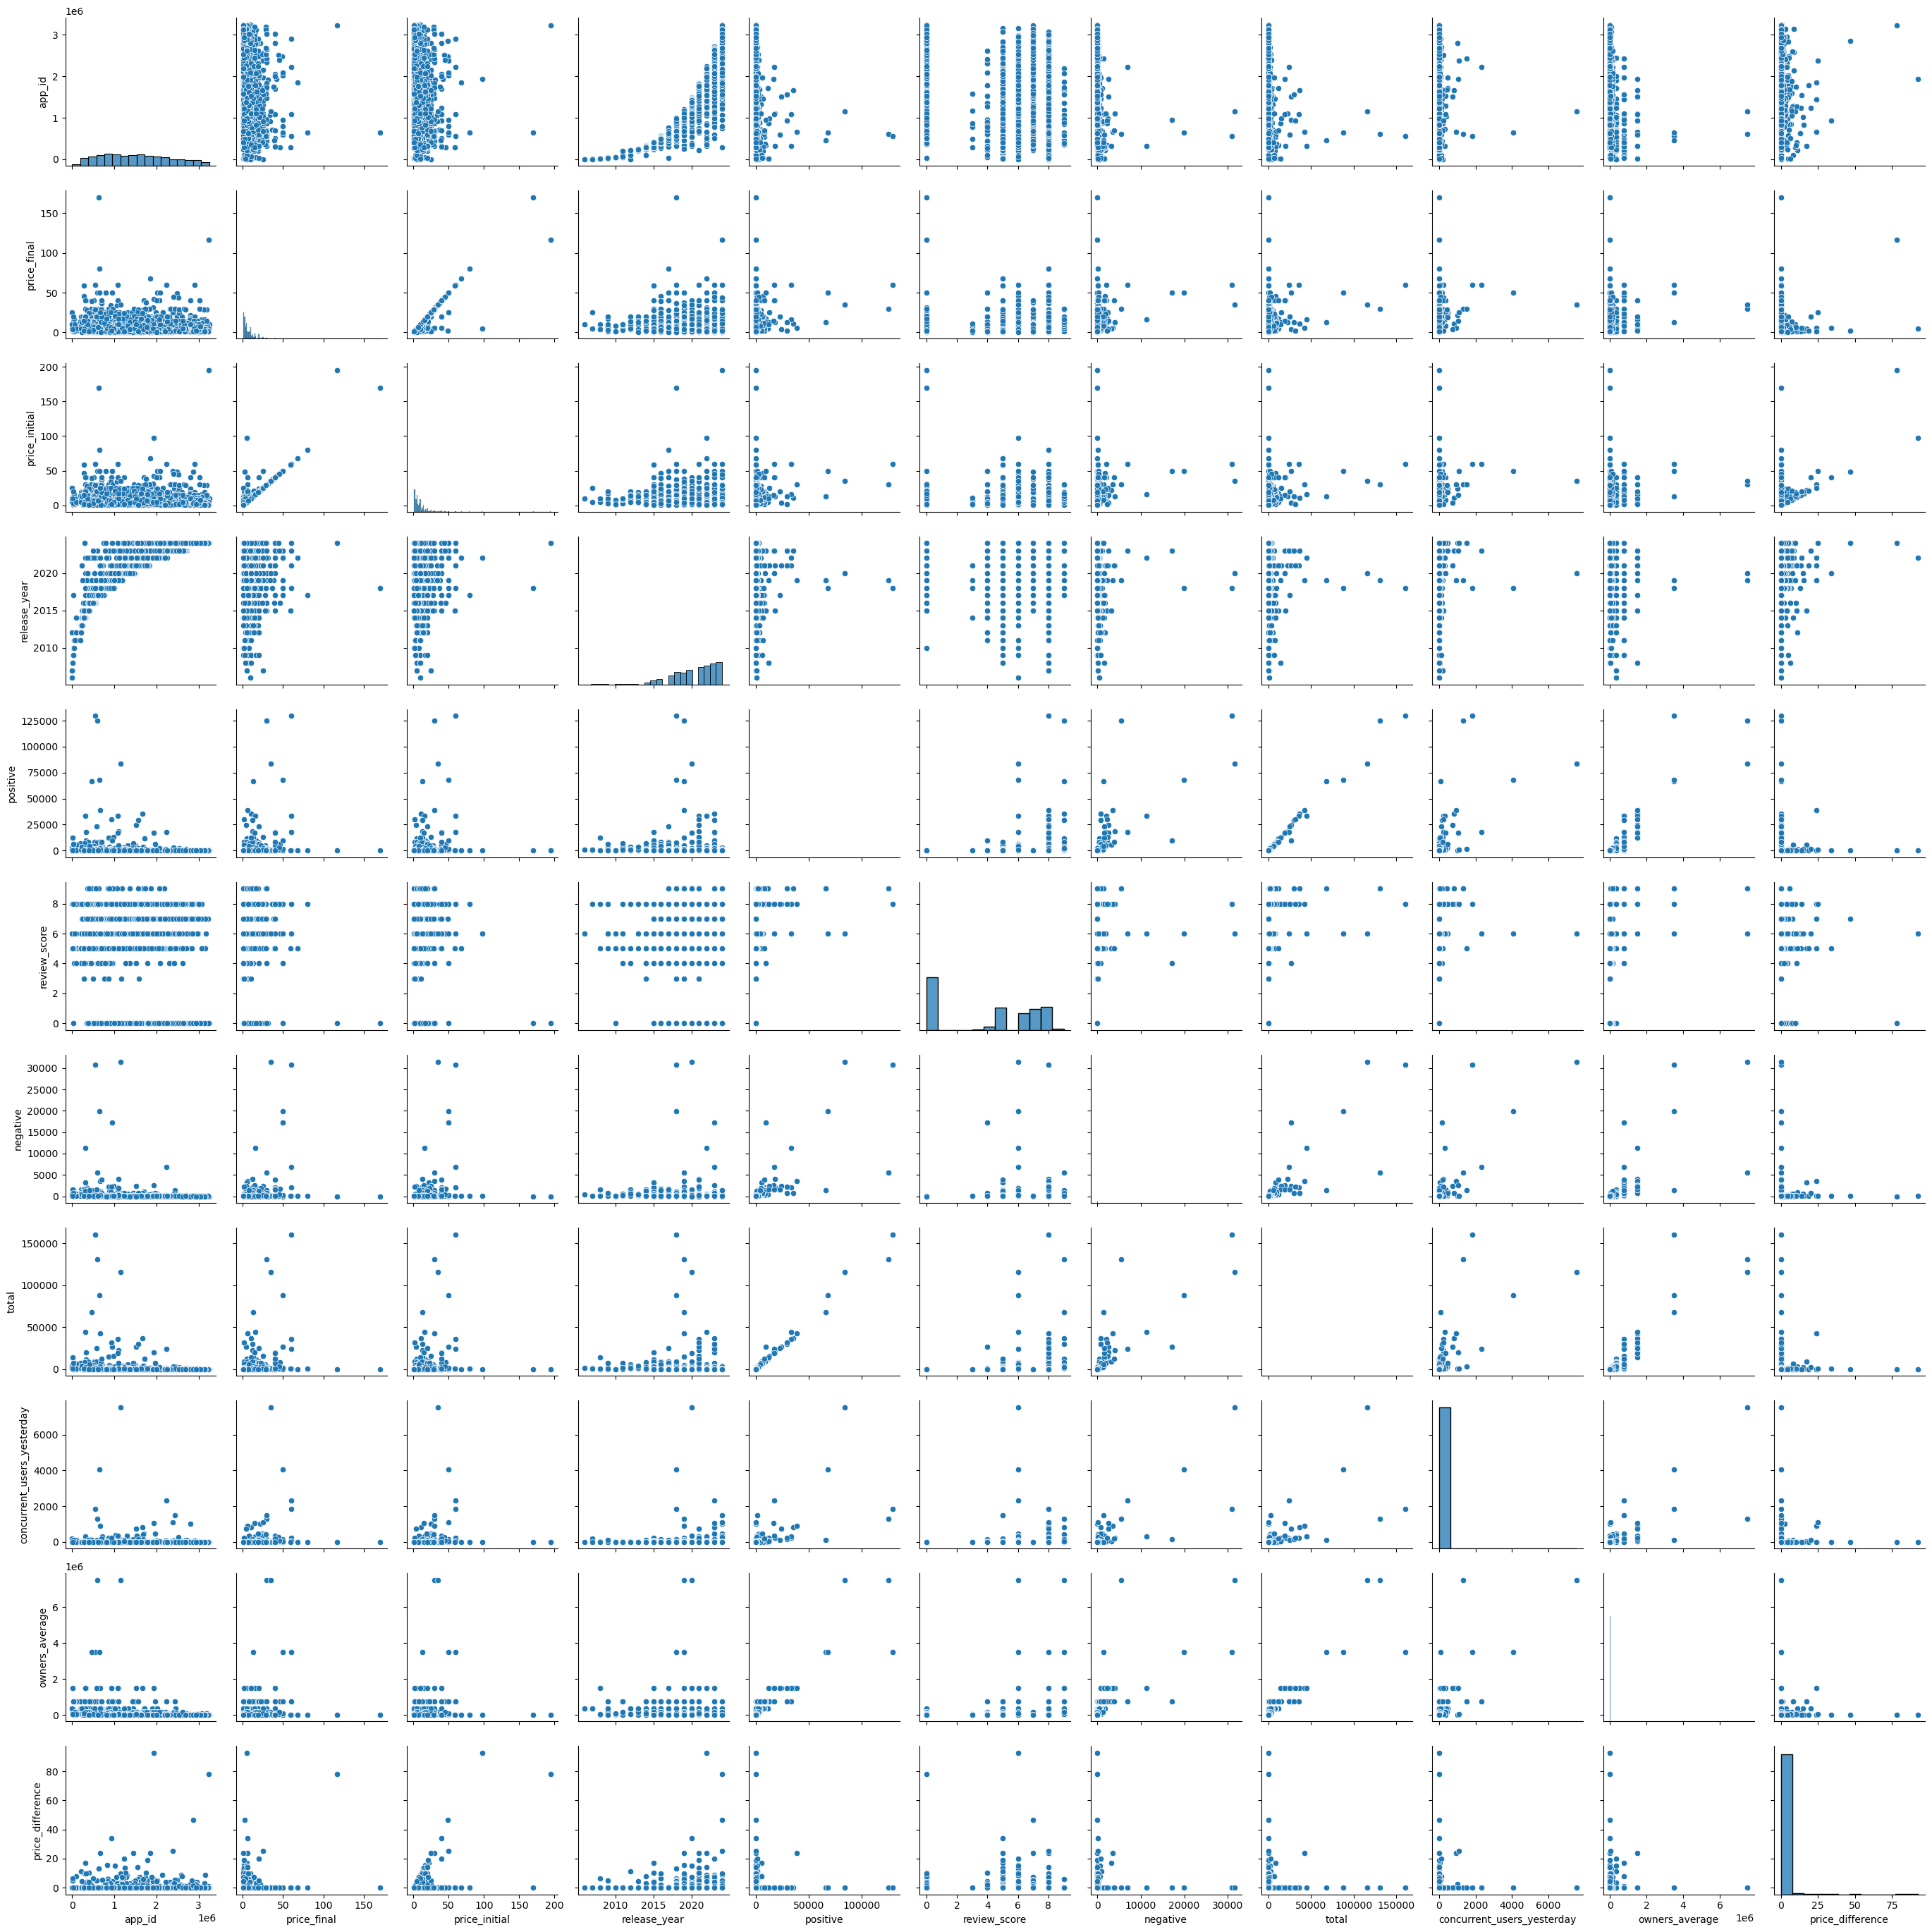

In [11]:
pairplot_data = filtered_paid_games[['app_id','price_final', 'price_initial', 'release_year', 'positive', 'review_score', 'negative', 'total', 'concurrent_users_yesterday', 'owners_average', 'price_difference']]
sampled_data = pairplot_data.sample(n=2000, random_state=42)

# Create the pairplot
pairplot = sns.pairplot(sampled_data)
plt.tight_layout()
plt.show()

<Axes: >

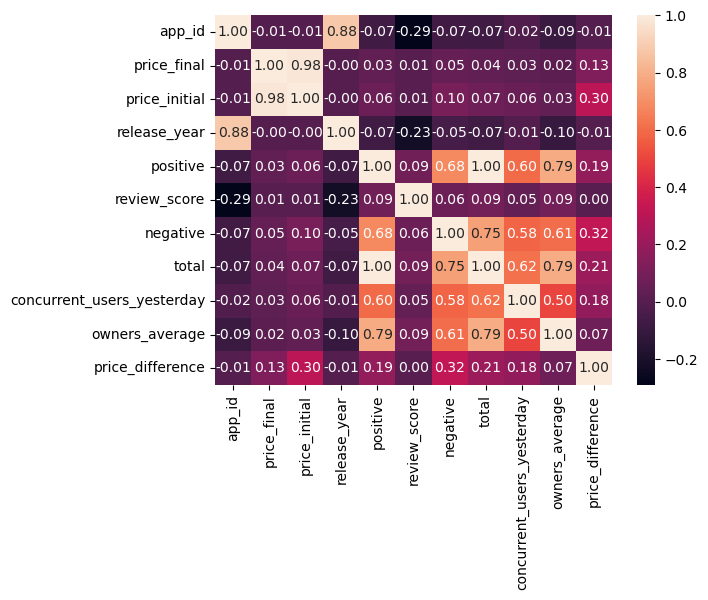

In [12]:
sns.heatmap(
    pairplot_data.corr(),
    annot=True,         # Show the correlation values
    fmt='.2f',          # Format string for annotations (2 decimal places)
)

PC1 explains 48.22% of variance
PC2 explains 17.48% of variance

Component loadings:
                                 PC1       PC2
app_id                     -0.242055  0.454020
price_final                 0.210688  0.495045
price_initial               0.227482  0.491368
release_year               -0.203741  0.513016
positive                    0.409392  0.000731
review_score                0.298628 -0.042293
negative                    0.398111 -0.053228
total                       0.414768 -0.017092
concurrent_users_yesterday  0.317512  0.186993
owners_average              0.334996 -0.063639
price_difference            0.058479  0.015386


C:\Users\Georg\AppData\Local\Temp\ipykernel_67452\2690265841.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


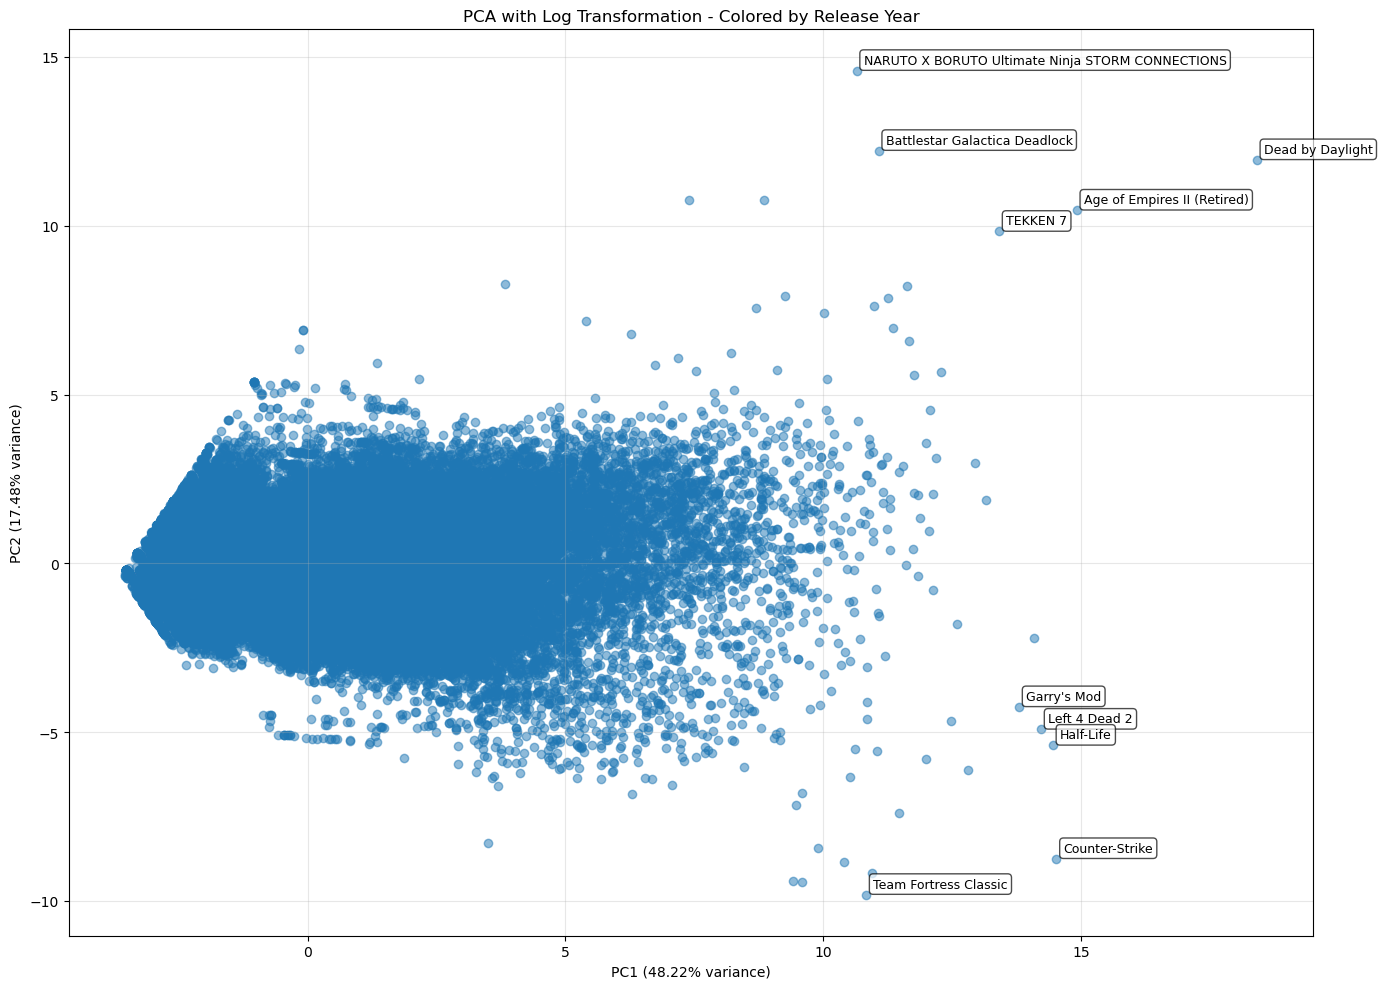

In [47]:
# handles zeros
log_data = np.log1p(pairplot_data)  

# Standardize the log-transformed data
scaler = StandardScaler()
scaled_log_data = scaler.fit_transform(log_data)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_log_data)

# Store PCA values in a DataFrame with original indices
pca_df = pd.DataFrame(
    data=pca_result, 
    columns=['PC1', 'PC2'],
    index=pairplot_data.index
)

# Get the explained variance ratio (how much variance each PC explains)
explained_variance = pca.explained_variance_ratio_
print(f"PC1 explains {explained_variance[0]:.2%} of variance")
print(f"PC2 explains {explained_variance[1]:.2%} of variance")

# To see component loadings (how each original feature contributes to each PC)
component_loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=pairplot_data.columns
)
print("\nComponent loadings:")
print(component_loadings)

# You can also save these values to CSV if needed
pca_df.to_csv('pca_coordinates.csv')
component_loadings.to_csv('pca_loadings.csv')

# Create a visualization with color coding by release year
plt.figure(figsize=(14, 10))

# Create scatter plot
scatter = plt.scatter(
    pca_result[:, 0], 
    pca_result[:, 1], 
    cmap='viridis', 
    alpha=0.5
)

# Add labels and title
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
plt.title('PCA with Log Transformation - Colored by Release Year')

# Add a grid for better readability
plt.grid(alpha=0.3)

# Calculate distance from origin for each point to identify outliers
distances = np.sqrt(pca_result[:, 0]**2 + pca_result[:, 1]**2)
top_n = 10  # Number of outliers to label

# Get indices of top N outliers
outlier_indices = np.argsort(distances)[-top_n:]

# Annotate these outliers
for idx in outlier_indices:
    x, y = pca_result[idx, 0], pca_result[idx, 1]
    
    # Get the app_id for this row
    app_id = pairplot_data.index[idx] 
    game_name = filtered_paid_games.loc[app_id, 'name']
        
    # Add annotation
    plt.annotate(game_name, (x, y), 
                 xytext=(5, 5), 
                 textcoords='offset points',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7),
                 fontsize=9)

plt.tight_layout()
plt.show()

### Projecting PC1 and PC2 to each game 

In [14]:
# Copy data frame with PCA features 
features = ['app_id','price_final', 'price_initial', 'release_year', 'positive', 'review_score', 'negative', 'total', 'concurrent_users_yesterday', 'owners_average', 'price_difference']
temp = filtered_paid_games.copy()
PCA_features = temp[features]
log_features = np.log1p(PCA_features)  

# Standardise features 
scaler = StandardScaler()
log_features_scaled = scaler.fit_transform(log_features)

# Dataframe of standardized logged features 
PCA_features_df = pd.DataFrame(log_features_scaled, columns=features)

# Initialise PC values for every game 
filtered_paid_games['PC1_score'] = 0
filtered_paid_games['PC2_score'] = 0

for i, row in PCA_features_df.iterrows():
  # Calculate PC1 
  pc1_score = 0
  for feature in features:
    pc1_score += row[feature] * component_loadings['PC1'][feature]

  pc2_score = 0
  for feature in features:
    pc2_score += row[feature] * component_loadings['PC2'][feature]

  # The problem is here - use .at or .loc for assignment
  filtered_paid_games.at[i, 'PC1_score'] = pc1_score
  filtered_paid_games.at[i, 'PC2_score'] = pc2_score

C:\Users\Georg\AppData\Local\Temp\ipykernel_67452\1207707355.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.526505142770342' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_paid_games.at[i, 'PC1_score'] = pc1_score
C:\Users\Georg\AppData\Local\Temp\ipykernel_67452\1207707355.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-8.746749027115722' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_paid_games.at[i, 'PC2_score'] = pc2_score


### How different game genres have risen and fallen over time 

In [15]:
PCA_paid_games = filtered_paid_games.explode('genre')

# Sort every genre and year combination with an average PC1 Score 
genre_year_PC = PCA_paid_games[['app_id', 'name', 'release_year', 'genre', 'PC1_score', 'PC2_score']]

genre_year_analysis = genre_year_PC.groupby(['genre', 'release_year']).agg({
    'PC1_score': 'mean',
    'PC2_score': 'mean',
    'app_id': 'count'  # Use app_id instead of 'Count'
}).reset_index()

# Rename the count column for clarity
genre_year_analysis = genre_year_analysis.rename(columns={'app_id': 'game_count'})

genre_year_analysis = genre_year_analysis.sort_values(['genre', 'release_year'])

genre_year_analysis.head()

,genre,release_year,PC1_score,PC2_score,game_count
0,Action,1997,5.143380,-4.434392,1
1,Action,1998,14.458159,-5.388520,1
2,Action,1999,10.891931,-9.494140,2
3,Action,2000,12.056516,-9.098522,2
4,Action,2001,9.386859,-7.224970,3


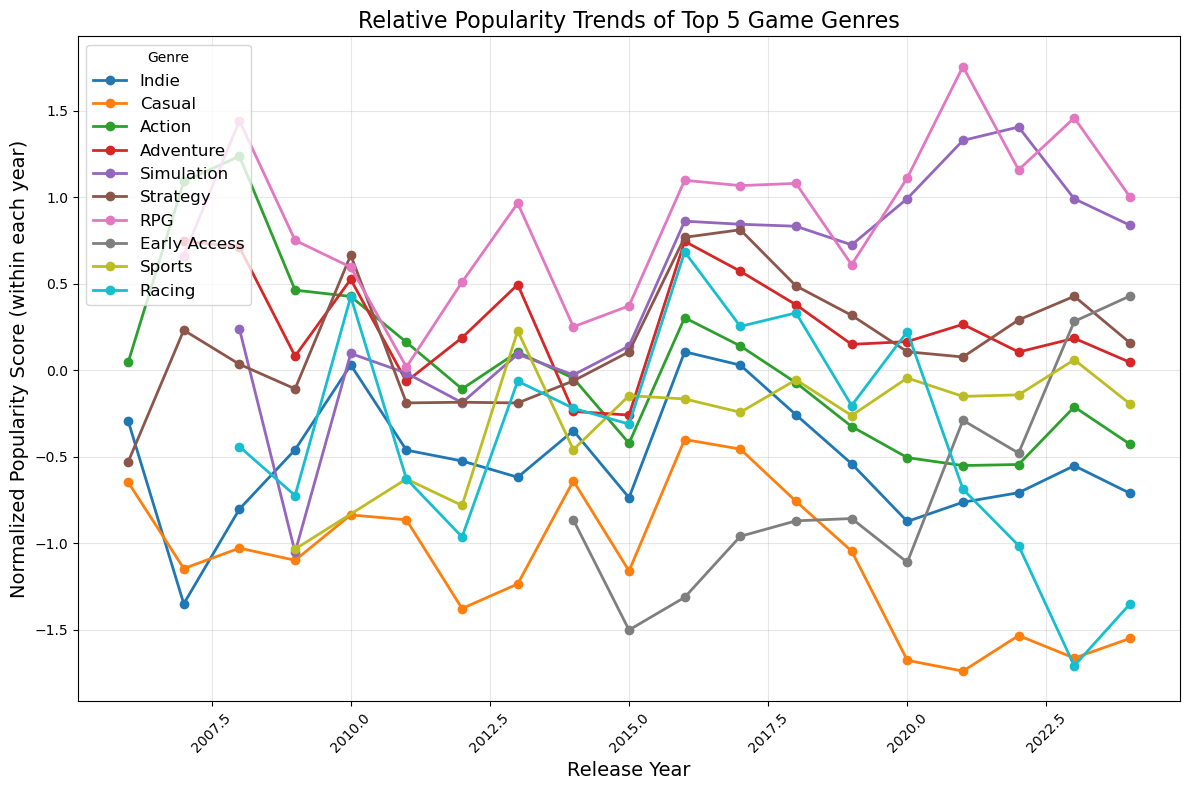

In [45]:
# Normalize PC1 scores within each year
def normalize_within_year(df, score_column='PC1_score'):
    """
    Normalize scores within each year to make them comparable across time periods
    This gives each genre's relative standing within its year
    """
    # Group by release year
    yearly_groups = df.groupby('release_year')
    
    # Create a new column for normalized scores
    df['PC1_normalized'] = df[score_column].copy()
    
    # For each year, normalize the scores
    for year, group in yearly_groups:
        # Get the scores for this year
        year_scores = df.loc[df['release_year'] == year, score_column]
        
        # Calculate mean and standard deviation
        mean = year_scores.mean()
        std = year_scores.std()
        
        # If standard deviation is 0 or very small, set normalized values to 0
        if std < 0.001:
            df.loc[df['release_year'] == year, 'PC1_normalized'] = 0
        else:
            # Z-score normalization: (x - mean) / std
            df.loc[df['release_year'] == year, 'PC1_normalized'] = (year_scores - mean) / std
    
    return df

# Apply normalization to your dataframe
genre_year_analysis = normalize_within_year(genre_year_analysis)

# Now plot using the normalized scores
plt.figure(figsize=(12, 8))

# Get top 5 genres by total game count
top_genres = genre_year_analysis.groupby('genre')['game_count'].sum().nlargest(10).index

# Plot only those top 5 genres
for genre in top_genres:
    data = genre_year_analysis[genre_year_analysis['genre'] == genre]
    # Filter to include only years with a minimum number of games
    data = data[data['game_count'] >= 5]  # Adjust threshold as needed
    plt.plot(data['release_year'], data['PC1_normalized'], marker='o', linewidth=2, label=genre)

plt.title('Relative Popularity Trends of Top 5 Game Genres', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Normalized Popularity Score (within each year)', fontsize=14)
plt.legend(title='Genre', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: >

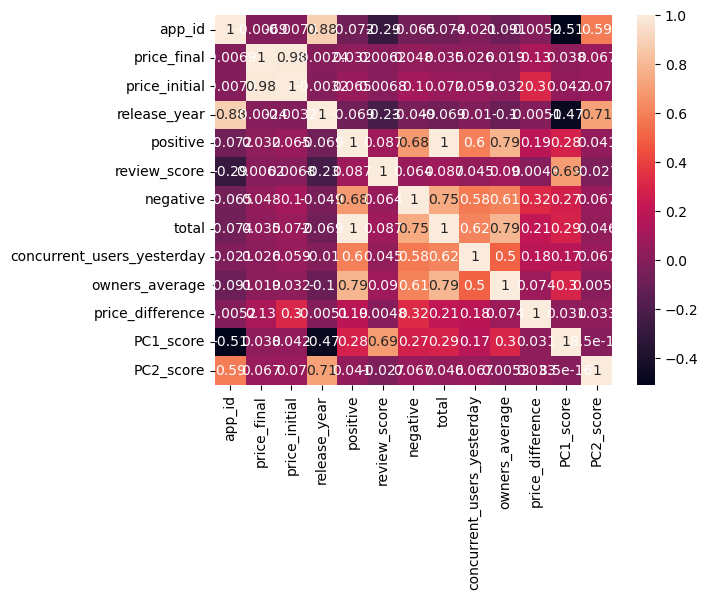

In [17]:
heat_map = filtered_paid_games[['app_id','price_final', 'price_initial', 'release_year', 'positive', 'review_score', 'negative', 'total', 'concurrent_users_yesterday', 'owners_average', 'price_difference', 'PC1_score', 'PC2_score']]

sns.heatmap(heat_map.corr(), annot=True)

## Temporal Trends 

### Genre Evolution Over Time by number of games in genre vs release year - Paid Games

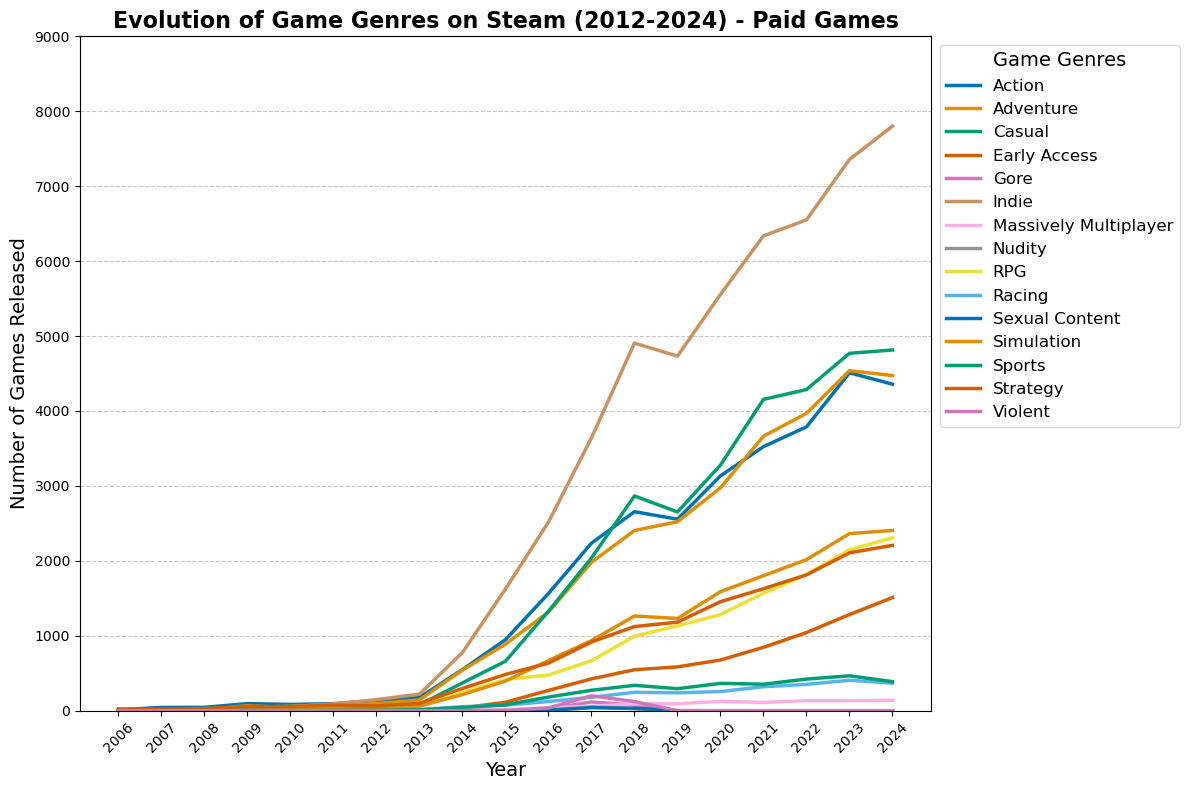

In [18]:
# Use the existing filtered_paid_games dataset instead of reprocessing
# We need to explode the genre list since it was aggregated in your preprocessing
genre_data = filtered_paid_games.explode('genre')       # Explode expands the list 

# Count games by release year and genre
genre_counts = genre_data.groupby(['release_year', 'genre']).size().reset_index(name='count')

# Create pivot table
genre_pivot = genre_counts.pivot(index='release_year', columns='genre', values='count')
genre_pivot = genre_pivot.fillna(0)
genre_pivot = genre_pivot.sort_index()
genre_pivot = genre_pivot.loc[2006:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam (2012-2024) - Paid Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Games Released", fontsize=14)
plt.ylim((0,9000))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
           loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()


- There had been a blast in indie games released 

### Genre Evolution Over Time by number of games in genre vs release year - Free Games

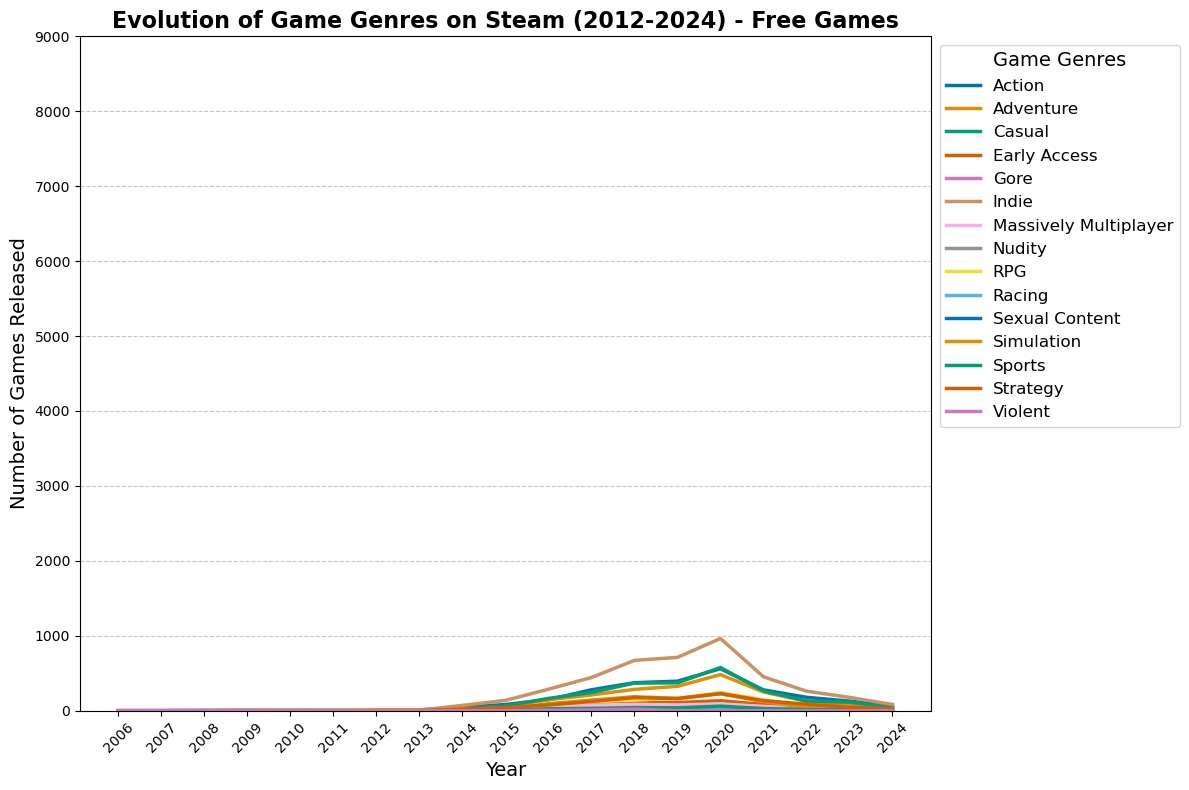

In [19]:
# Use the existing filtered_free_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
genre_data = filtered_free_games.explode('genre')

# Count games by release year and genre
genre_counts = genre_data.groupby(['release_year', 'genre']).size().reset_index(name='count')

# Create pivot table
genre_pivot = genre_counts.pivot(index='release_year', columns='genre', values='count')
genre_pivot = genre_pivot.fillna(0)
genre_pivot = genre_pivot.sort_index()
genre_pivot = genre_pivot.loc[2006:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam (2012-2024) - Free Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Games Released", fontsize=14)
plt.ylim((0,9000))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
           loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()

- Free games peaked in 2020 by release 

### Genre Evolution Over Time by positive reviews in genre vs release year - Paid Games 

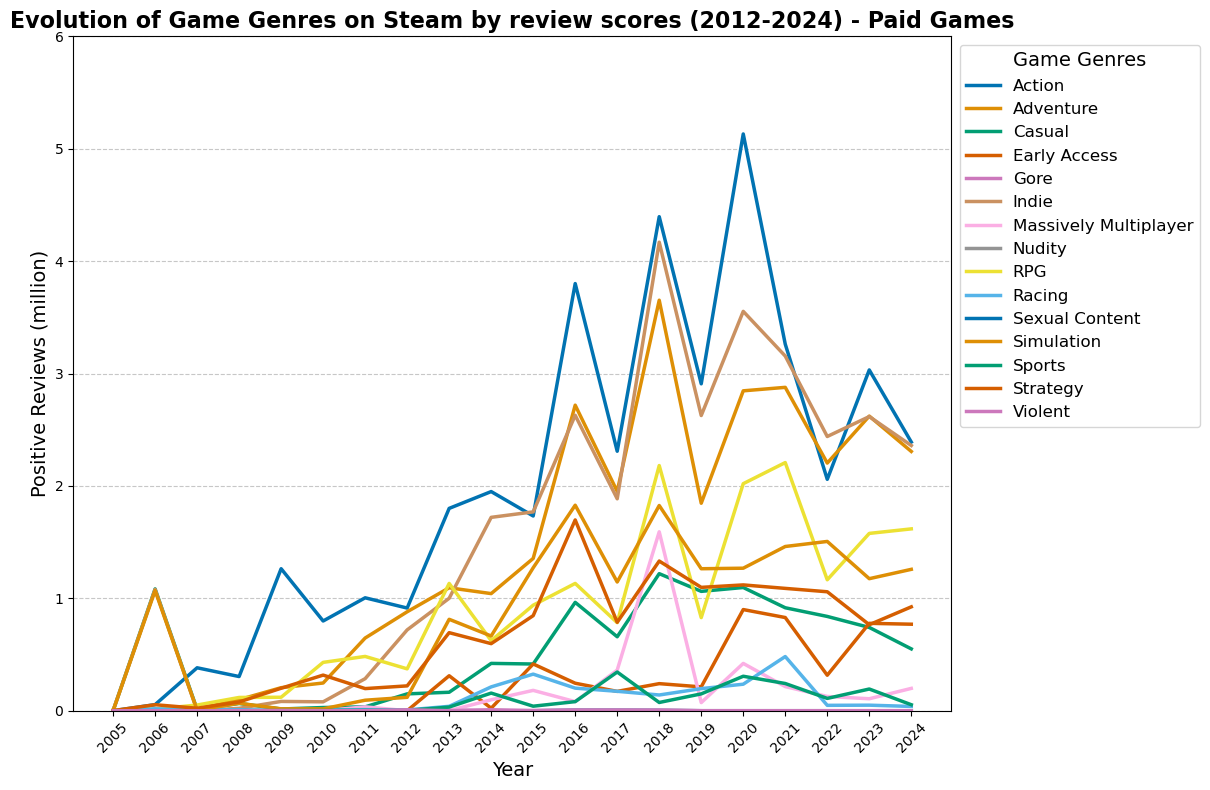

In [20]:
# Use the existing filtered_paid_games dataset 
# We need to explode the genre list since it was aggregated in your preprocessing
reviews_data = filtered_paid_games.explode('genre')

# Group by release_year and genre, and sum the positive reviews
genre_reviews = reviews_data.groupby(['release_year', 'genre'])['positive'].sum().reset_index()

# Convert the number of positive reviews to millions 
genre_reviews['positive'] = genre_reviews['positive']/1000000

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_reviews.pivot(index='release_year', columns='genre', values='positive')

# Fill any NaN values with 0 (years where a genre had no positive reviews)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

genre_pivot = genre_pivot.loc[2005:]


# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by review scores (2012-2024) - Paid Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Positive Reviews (million)", fontsize=14)
plt.ylim((0,6))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()


### Genre Evolution Over Time by positive reviews in genre vs release year - Free Games 

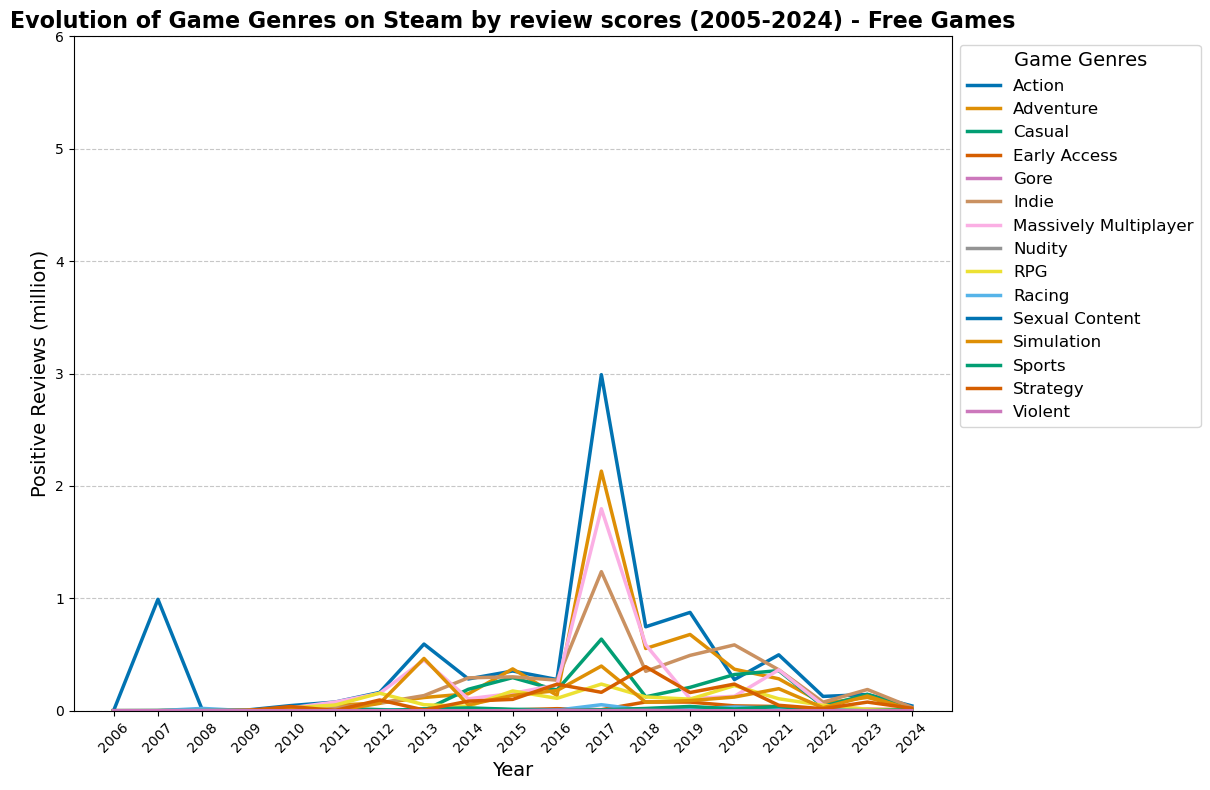

In [21]:
# Use the existing filtered_free_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
reviews_data = filtered_free_games.explode('genre')

# Group by release_year and genre, and sum the positive reviews
genre_reviews = reviews_data.groupby(['release_year', 'genre'])['positive'].sum().reset_index()

# Convert the number of positive reviews to millions 
genre_reviews['positive'] = genre_reviews['positive']/1000000

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_reviews.pivot(index='release_year', columns='genre', values='positive')

# Fill any NaN values with 0 (years where a genre had no positive reviews)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

# Filter to years >= 2005 (changed from 2012 as requested)
genre_pivot = genre_pivot.loc[2005:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by review scores (2005-2024) - Free Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Positive Reviews (million)", fontsize=14)
plt.ylim((0,6))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()

### Genre Evolution Over Time by player count in genre vs release year - Paid Games

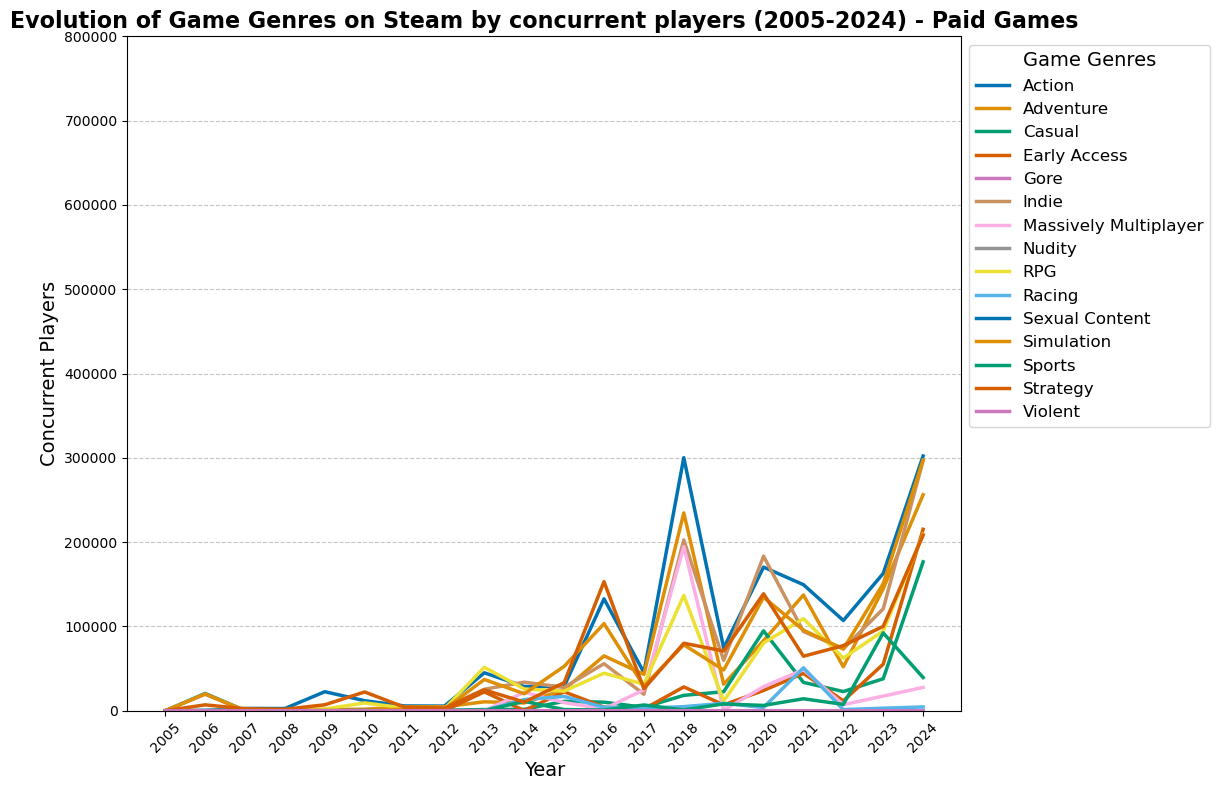

In [22]:
# Use the existing filtered_paid_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
players_data = filtered_paid_games.explode('genre')

# Group by release_year and genre, and sum the concurrent users
genre_players = players_data.groupby(['release_year', 'genre'])['concurrent_users_yesterday'].sum().reset_index()

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_players.pivot(index='release_year', columns='genre', values='concurrent_users_yesterday')

# Fill any NaN values with 0 (years where a genre had no concurrent players)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

# Filter to years >= 2005 (changed from 2012)
genre_pivot = genre_pivot.loc[2005:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by concurrent players (2005-2024) - Paid Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Concurrent Players", fontsize=14)
plt.ylim((0,800000))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()


### Genre Evolution Over Time by player count in genre vs release year - Free Games

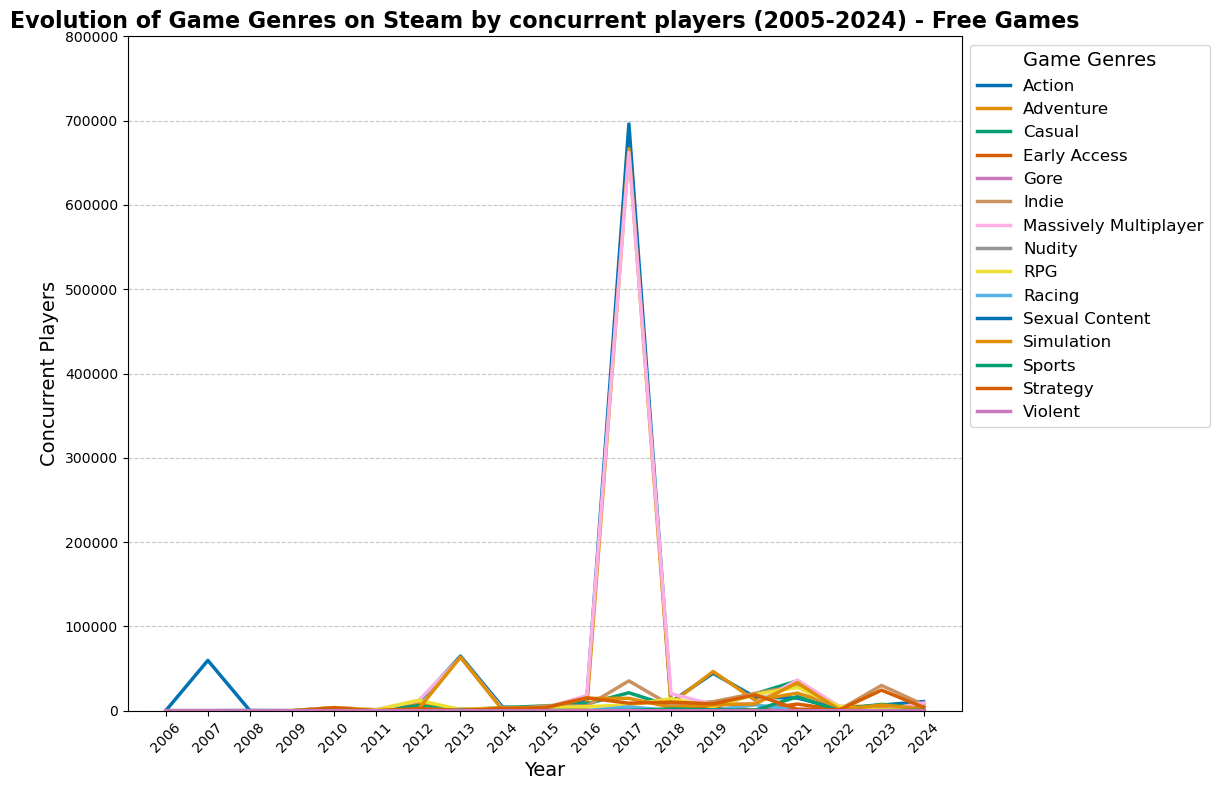

In [23]:
# Use the existing filtered_free_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
players_data = filtered_free_games.explode('genre')

# Group by release_year and genre, and sum the concurrent users
genre_players = players_data.groupby(['release_year', 'genre'])['concurrent_users_yesterday'].sum().reset_index()

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_players.pivot(index='release_year', columns='genre', values='concurrent_users_yesterday')

# Fill any NaN values with 0 (years where a genre had no concurrent players)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

# Filter to years >= 2005 (changed from 2012)
genre_pivot = genre_pivot.loc[2005:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by concurrent players (2005-2024) - Free Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Concurrent Players", fontsize=14)
plt.ylim((0,800000))

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()

### Sales vs Year categorised into genres - Paid Games

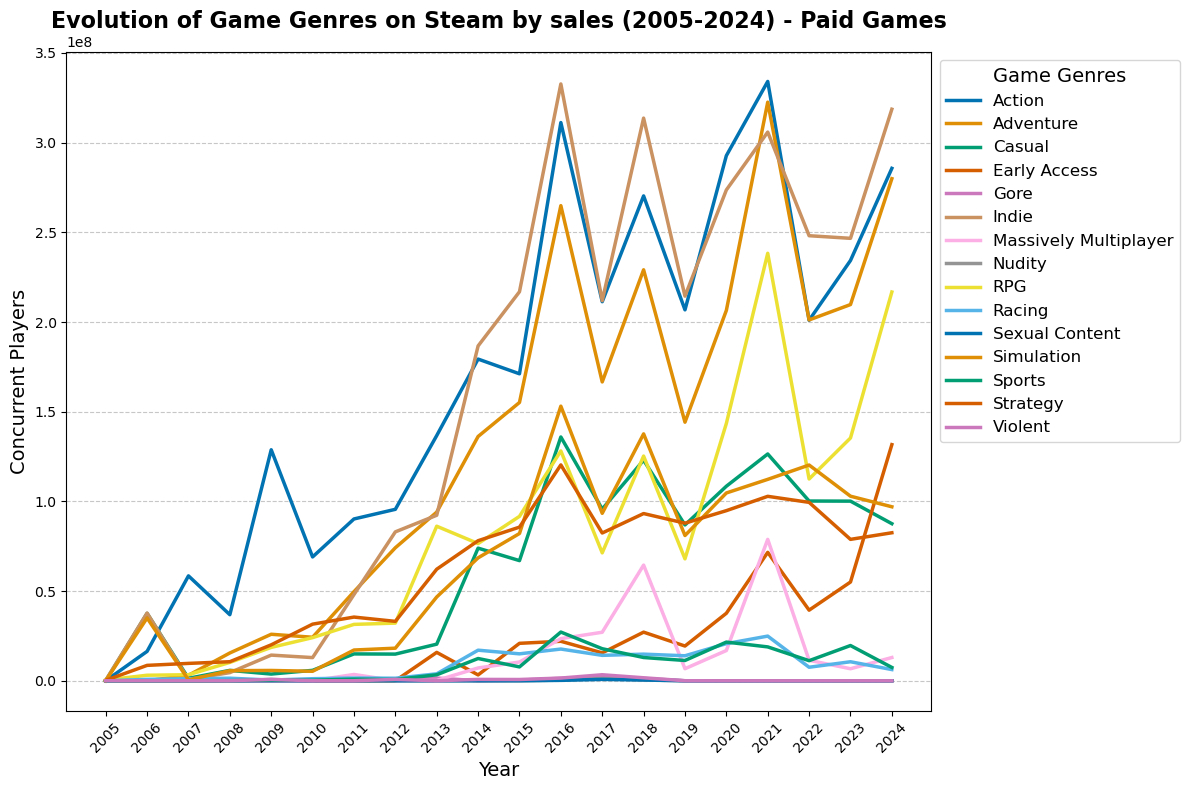

In [24]:
# Use the existing filtered_paid_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
players_data = filtered_paid_games.explode('genre')

# Group by release_year and genre, and sum the concurrent users
genre_players = players_data.groupby(['release_year', 'genre'])['owners_average'].sum().reset_index()

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_players.pivot(index='release_year', columns='genre', values='owners_average')

# Fill any NaN values with 0 (years where a genre had no concurrent players)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

# Filter to years >= 2005 (changed from 2012)
genre_pivot = genre_pivot.loc[2005:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by sales (2005-2024) - Paid Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Concurrent Players", fontsize=14)

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()

### Sales vs Year categorised into genres - Free Games

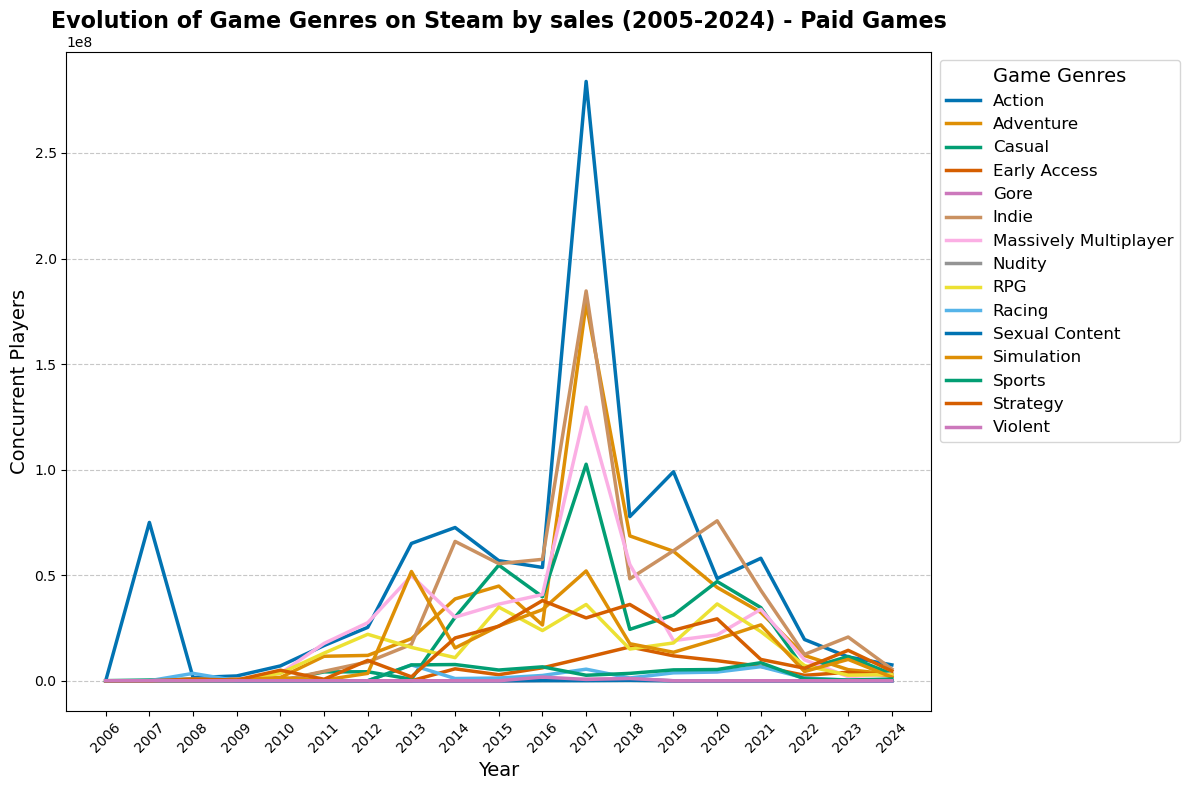

In [25]:
# Use the existing filtered_paid_games dataset
# We need to explode the genre list since it was aggregated in your preprocessing
players_data = filtered_free_games.explode('genre')

# Group by release_year and genre, and sum the concurrent users
genre_players = players_data.groupby(['release_year', 'genre'])['owners_average'].sum().reset_index()

# Now create a pivot table with years as rows and genres as columns
genre_pivot = genre_players.pivot(index='release_year', columns='genre', values='owners_average')

# Fill any NaN values with 0 (years where a genre had no concurrent players)
genre_pivot = genre_pivot.fillna(0)

# Sort by year
genre_pivot = genre_pivot.sort_index()

# Filter to years >= 2005 (changed from 2012)
genre_pivot = genre_pivot.loc[2005:]

# Set figure size for better visibility
plt.figure(figsize=(12, 8))

# Plot the data with a visually distinct color palette
colors = sns.color_palette("colorblind", n_colors=len(genre_pivot.columns))
genre_pivot.plot(kind='line', color=colors, linewidth=2.5, ax=plt.gca())

# Add appropriate labels
plt.title("Evolution of Game Genres on Steam by sales (2005-2024) - Paid Games", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Concurrent Players", fontsize=14)

# Format the axes
plt.xticks(genre_pivot.index, rotation=45)  # Rotate year labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle grid lines

# Enhance the legend
plt.legend(title="Game Genres", fontsize=12, title_fontsize=14, 
     loc='upper left', bbox_to_anchor=(1, 1))

# Ensure labels are visible
plt.tight_layout()

# Show plot
plt.show()

### Exploring top paid games in 2018

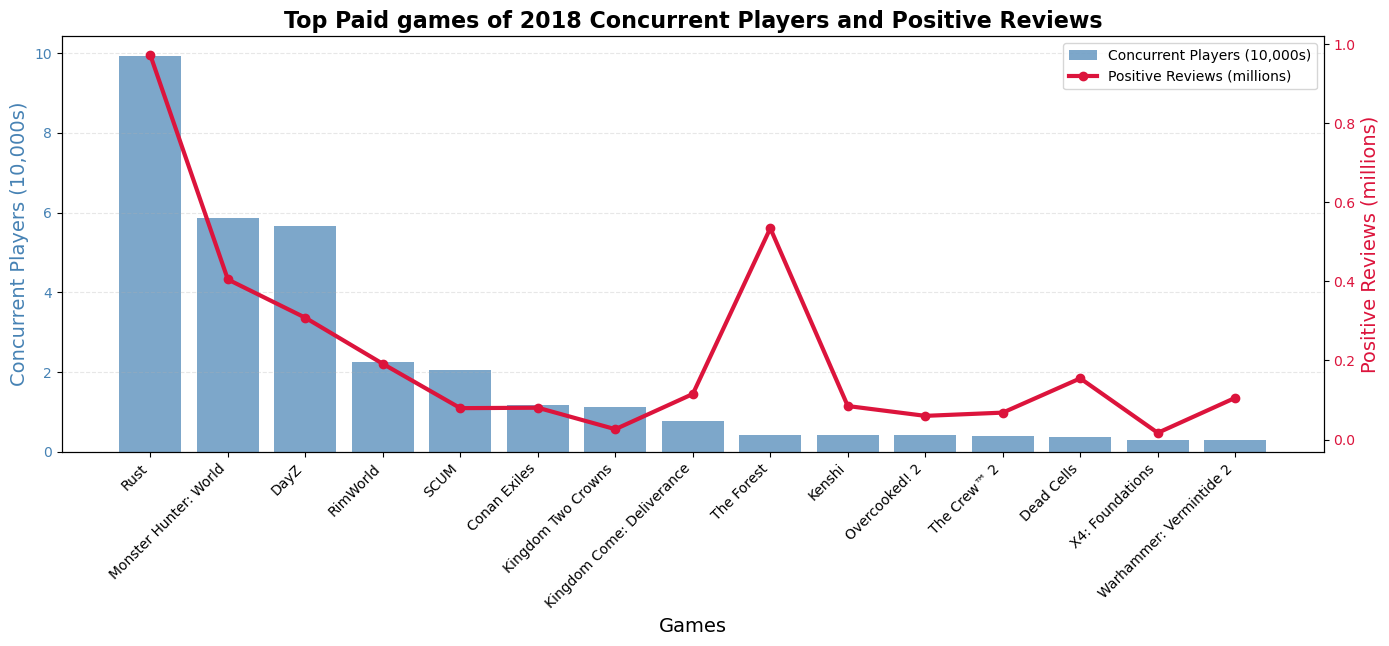

In [26]:
# Explode the genre column from filtered_paid_games
paid_games_2018 = filtered_paid_games.explode('genre')

# Filter for games released in 2018
paid_games_2018 = paid_games_2018[paid_games_2018['release_year'] == 2018]

# Filter for only the top genres
paid_games_2018 = paid_games_2018[(paid_games_2018['genre'] == 'Indie') |
                                  (paid_games_2018['genre'] == 'Action') |
                                  (paid_games_2018['genre'] == 'Adventure') |
                                  (paid_games_2018['genre'] == 'Massively Multiplayer') |
                                  (paid_games_2018['genre'] == 'RPG') |
                                  (paid_games_2018['genre'] == 'Simulation')]

# Re-aggregate the genres into lists by game
paid_games_2018 = paid_games_2018.groupby(['app_id', 'name','release_year', 'positive', 
                                           'concurrent_users_yesterday'])['genre'].agg(list).reset_index()

# Display the first few rows
top_paid_games_2018 = paid_games_2018.sort_values('concurrent_users_yesterday', ascending=False)
top_paid_games_2018 = top_paid_games_2018[top_paid_games_2018['concurrent_users_yesterday'] >= 2844]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Sort by concurrent players descending
top_games = top_paid_games_2018.copy()

# Convert to appropriate scales
top_games['concurrent_users_scaled'] = top_games['concurrent_users_yesterday'] / 10000
top_games['positive_millions'] = top_games['positive'] / 1000000

# Plot concurrent players as bars on the primary axis (in 10,000s)
bars = ax1.bar(range(len(top_games)), top_games['concurrent_users_scaled'], color='steelblue', alpha=0.7, label='Concurrent Players')
ax1.set_xlabel('Games', fontsize=14)
ax1.set_ylabel('Concurrent Players (10,000s)', color='steelblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Create the secondary axis for positive reviews (in millions)
ax2 = ax1.twinx()
line = ax2.plot(range(len(top_games)), top_games['positive_millions'], color='crimson', marker='o', linewidth=3, label='Positive Reviews')[0]
ax2.set_ylabel('Positive Reviews (millions)', color='crimson', fontsize=14)
ax2.tick_params(axis='y', labelcolor='crimson')

# Set the game names as x-tick labels - force 45 degree rotation
ax1.set_xticks(range(len(top_games)))
ax1.set_xticklabels(top_games['name'], rotation=45, ha='right')

# Add title and grid
plt.title('Top Paid games of 2018 Concurrent Players and Positive Reviews', fontsize=16, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend without custom lines
ax1.legend([bars, line], ['Concurrent Players (10,000s)', 'Positive Reviews (millions)'], loc='upper right')

# Add bottom padding for the rotated labels
plt.subplots_adjust(bottom=0.3)

# Apply tight layout but with specific bottom padding
fig.tight_layout(rect=[0, 0.15, 1, 0.97])

plt.show()


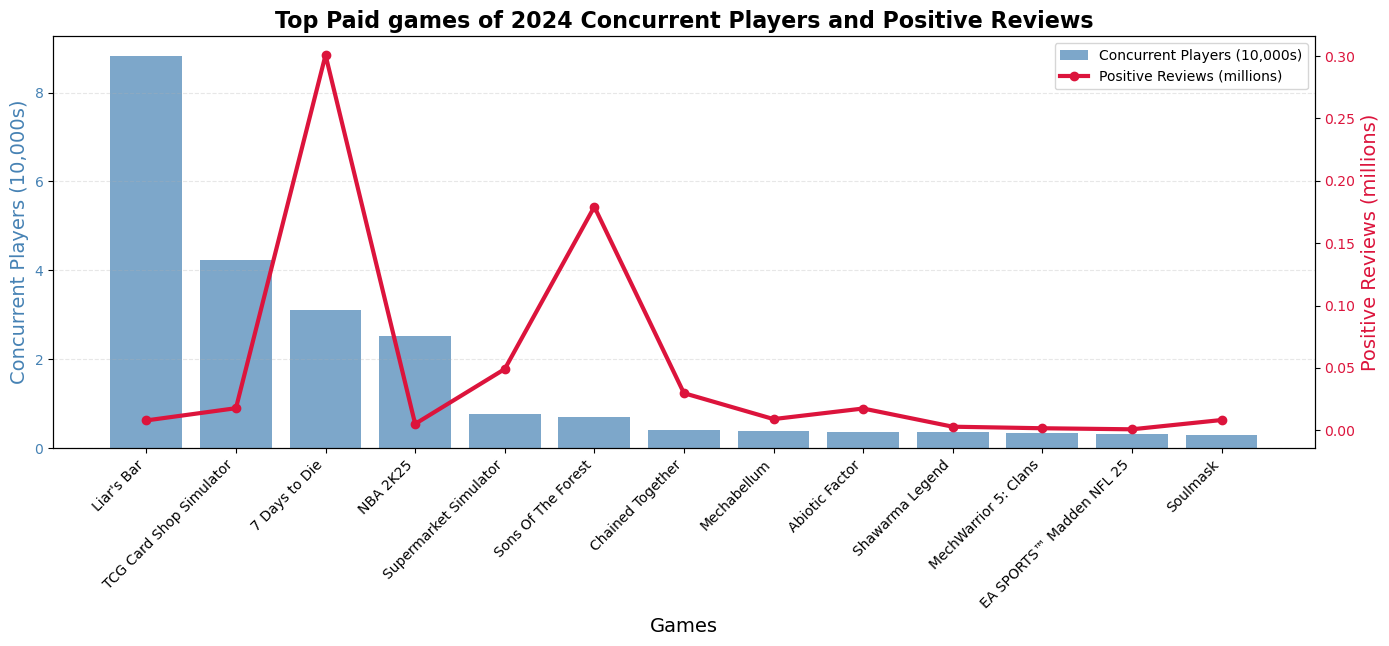

In [33]:
# Explode the genre column from filtered_paid_games
paid_games_2018 = filtered_paid_games.explode('genre')

# Filter for games released in 2018
paid_games_2018 = paid_games_2018[paid_games_2018['release_year'] == 2024]

# Filter for only the top genres
paid_games_2018 = paid_games_2018[
                                  (paid_games_2018['genre'] == 'Simulation')]

# Re-aggregate the genres into lists by game
paid_games_2018 = paid_games_2018.groupby(['app_id', 'name','release_year', 'positive', 
                                           'concurrent_users_yesterday'])['genre'].agg(list).reset_index()

# Display the first few rows
top_paid_games_2018 = paid_games_2018.sort_values('concurrent_users_yesterday', ascending=False)
top_paid_games_2018 = top_paid_games_2018[top_paid_games_2018['concurrent_users_yesterday'] >= 2844]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Sort by concurrent players descending
top_games = top_paid_games_2018.copy()

# Convert to appropriate scales
top_games['concurrent_users_scaled'] = top_games['concurrent_users_yesterday'] / 10000
top_games['positive_millions'] = top_games['positive'] / 1000000

# Plot concurrent players as bars on the primary axis (in 10,000s)
bars = ax1.bar(range(len(top_games)), top_games['concurrent_users_scaled'], color='steelblue', alpha=0.7, label='Concurrent Players')
ax1.set_xlabel('Games', fontsize=14)
ax1.set_ylabel('Concurrent Players (10,000s)', color='steelblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Create the secondary axis for positive reviews (in millions)
ax2 = ax1.twinx()
line = ax2.plot(range(len(top_games)), top_games['positive_millions'], color='crimson', marker='o', linewidth=3, label='Positive Reviews')[0]
ax2.set_ylabel('Positive Reviews (millions)', color='crimson', fontsize=14)
ax2.tick_params(axis='y', labelcolor='crimson')

# Set the game names as x-tick labels - force 45 degree rotation
ax1.set_xticks(range(len(top_games)))
ax1.set_xticklabels(top_games['name'], rotation=45, ha='right')

# Add title and grid
plt.title('Top Paid games of 2024 Concurrent Players and Positive Reviews', fontsize=16, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend without custom lines
ax1.legend([bars, line], ['Concurrent Players (10,000s)', 'Positive Reviews (millions)'], loc='upper right')

# Add bottom padding for the rotated labels
plt.subplots_adjust(bottom=0.3)

# Apply tight layout but with specific bottom padding
fig.tight_layout(rect=[0, 0.15, 1, 0.97])

plt.show()


### Pie chart of different genres in 2024 with the highest player count 

### Exploring top free games in 2017

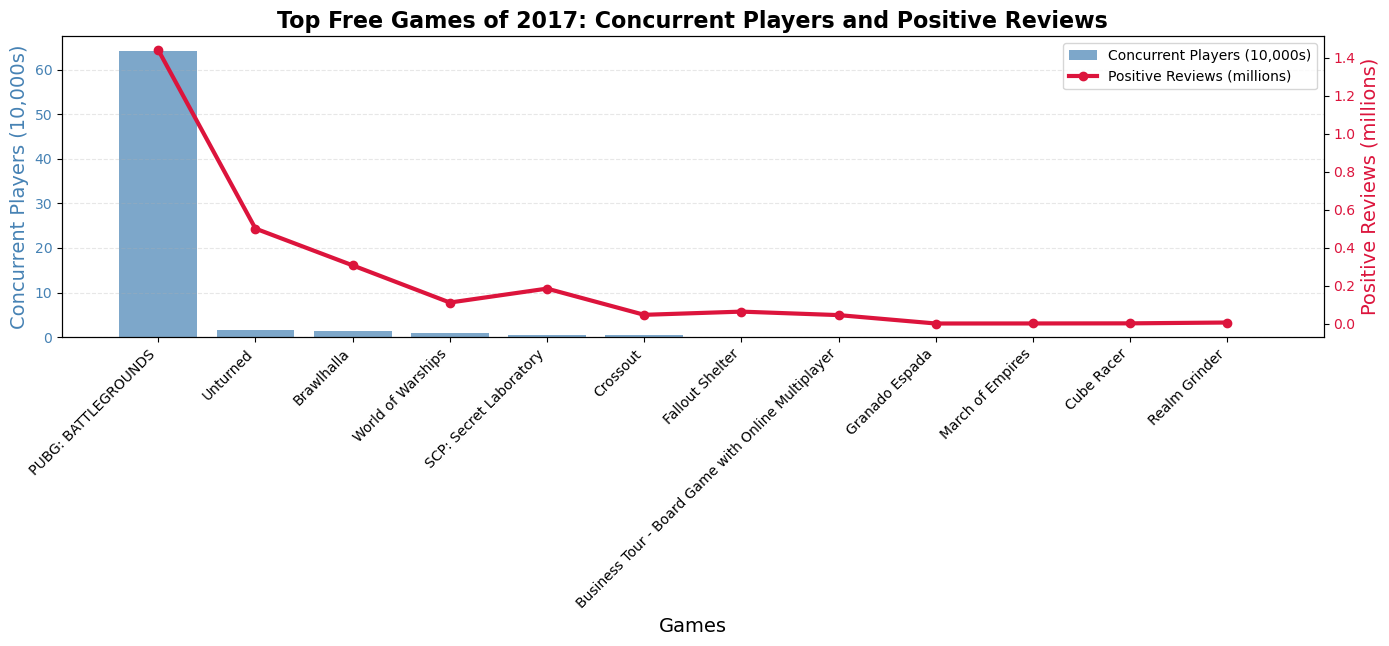

In [28]:
# Explode the genre column from filtered_free_games
free_games_2017 = filtered_free_games.explode('genre')

# Filter for games released in 2017
free_games_2017 = free_games_2017[free_games_2017['release_year'] == 2017]

# Filter for only the top genres
free_games_2017 = free_games_2017[(free_games_2017['genre'] == 'Indie') |
                                  (free_games_2017['genre'] == 'Action') |
                                  (free_games_2017['genre'] == 'Adventure') |
                                  (free_games_2017['genre'] == 'Massively Multiplayer') |
                                  (free_games_2017['genre'] == 'RPG')]

# Re-aggregate the genres into lists by game
free_games_2017 = free_games_2017.groupby(['app_id', 'name','release_year', 'positive', 
                                           'concurrent_users_yesterday'])['genre'].agg(list).reset_index()

# Sort by concurrent players and filter for minimum threshold
top_free_games_2017 = free_games_2017.sort_values('concurrent_users_yesterday', ascending=False)
top_free_games_2017 = top_free_games_2017[top_free_games_2017['concurrent_users_yesterday'] >= 500]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Convert to appropriate scales
top_free_games_2017['concurrent_users_scaled'] = top_free_games_2017['concurrent_users_yesterday'] / 10000
top_free_games_2017['positive_millions'] = top_free_games_2017['positive'] / 1000000

# Plot concurrent players as bars on the primary axis (in 10,000s)
bars = ax1.bar(range(len(top_free_games_2017)), top_free_games_2017['concurrent_users_scaled'], 
               color='steelblue', alpha=0.7, label='Concurrent Players')
ax1.set_xlabel('Games', fontsize=14)
ax1.set_ylabel('Concurrent Players (10,000s)', color='steelblue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Create the secondary axis for positive reviews (in millions)
ax2 = ax1.twinx()
line = ax2.plot(range(len(top_free_games_2017)), top_free_games_2017['positive_millions'], 
                color='crimson', marker='o', linewidth=3, label='Positive Reviews')[0]
ax2.set_ylabel('Positive Reviews (millions)', color='crimson', fontsize=14)
ax2.tick_params(axis='y', labelcolor='crimson')

# Set the game names as x-tick labels with 45-degree rotation
ax1.set_xticks(range(len(top_free_games_2017)))
ax1.set_xticklabels(top_free_games_2017['name'], rotation=45, ha='right')

# Add title and grid
plt.title('Top Free Games of 2017: Concurrent Players and Positive Reviews', fontsize=16, fontweight='bold')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend without custom lines
ax1.legend([bars, line], ['Concurrent Players (10,000s)', 'Positive Reviews (millions)'], loc='upper right')

# Add bottom padding for the rotated labels
plt.subplots_adjust(bottom=0.3)

# Apply tight layout but with specific bottom padding
fig.tight_layout(rect=[0, 0.15, 1, 0.97])

plt.show()

- Rust is the genre defining game of paid games in 2018
  - Filtered by the top genres of the year 
- PUBG is the genre defining game of free games in 2017 
  - Filtered by the top genres of the year 

### Neural Networks